In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '4'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import openai
#openai.api_key = os.environ['OPENAI_API_KEY']




openai.api_base = os.environ.get("OPENAI_API_BASE", "https://api.openai.com/v1")
from data.serialize import SerializerSettings
from models.utils import grid_iter
from models.promptcast import get_promptcast_predictions_data
from models.darts import get_arima_predictions_data
from models.llmtime import get_llmtime_predictions_data
from data.small_context import get_datasets
from models.validation_likelihood_tuning import get_autotuned_predictions_data
import logging
import pickle

def plot_preds(train, test, pred_dict, model_name, show_samples=False):
    pred = pred_dict['median']
    pred = pd.Series(pred, index=test.index)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.plot(train)
    plt.plot(test, label='Truth', color='black')
    plt.plot(pred, label=model_name, color='purple')
    # shade 90% confidence interval
    samples = pred_dict['samples']
    lower = np.quantile(samples, 0.05, axis=0)
    upper = np.quantile(samples, 0.95, axis=0)
    plt.fill_between(pred.index, lower, upper, alpha=0.3, color='purple')
    if show_samples:
        samples = pred_dict['samples']
        # convert df to numpy array
        samples = samples.values if isinstance(samples, pd.DataFrame) else samples
        for i in range(min(10, samples.shape[0])):
            plt.plot(pred.index, samples[i], color='purple', alpha=0.3, linewidth=1)
    plt.legend(loc='upper left')
    if 'NLL/D' in pred_dict:
        nll = pred_dict['NLL/D']
        if nll is not None:
            plt.text(0.03, 0.85, f'NLL/D: {nll:.2f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()



gpt4_hypers = dict(
    alpha=0.3,
    basic=True,
    temp=1.0,
    top_p=0.8,
    settings=SerializerSettings(base=10, prec=3, signed=True, time_sep=', ', bit_sep='', minus_sign='-')
)

gpt3_hypers = dict(
    temp=0.7,
    alpha=0.95,
    beta=0.3,
    basic=False,
    settings=SerializerSettings(base=10, prec=3, signed=True, half_bin_correction=True)
)


promptcast_hypers = dict(
    temp=0.7,
    settings=SerializerSettings(base=10, prec=0, signed=True, 
                                time_sep=', ',
                                bit_sep='',
                                plus_sign='',
                                minus_sign='-',
                                half_bin_correction=False,
                                decimal_point='')
)

arima_hypers = dict(p=[12,30], d=[1,2], q=[0])

model_hypers = {
    #'LLMTime GPT-3.5': {'model': 'gpt-3.5-turbo-instruct', **gpt3_hypers},
    'LLMTime GPT-4': {'model': 'gpt-4', **gpt4_hypers},
    #'LLMTime GPT-3': {'model': 'text-davinci-003', **gpt3_hypers},
    #'PromptCast GPT-3': {'model': 'text-davinci-003', **promptcast_hypers},
    'ARIMA': arima_hypers,
    
}

model_predict_fns = {

    #'LLMTime GPT-3': get_llmtime_predictions_data,
    #'LLMTime GPT-3.5': get_llmtime_predictions_data,
    'LLMTime GPT-4': get_llmtime_predictions_data,
    #'PromptCast GPT-3': get_promptcast_predictions_data,
    'ARIMA': get_arima_predictions_data,
}

model_names = list(model_predict_fns.keys())



In [2]:
x = np.linspace(0,10,100)
train = np.sin(x[0:50])
test = np.sin(x[50:100])

In [3]:
model_hypers['LLMTime GPT-4']
hypers = list(grid_iter(model_hypers['LLMTime GPT-4']))
hypers


[defaultdict(dict,
             {'model': 'gpt-4',
              'alpha': 0.3,
              'basic': True,
              'temp': 1.0,
              'top_p': 0.8,
              'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan')})]

In [4]:
pred_dict_gpt_sine = get_autotuned_predictions_data(train, test, hypers, 10, model_predict_fns['LLMTime GPT-4'], verbose=False, parallel=False)

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan')}) 
 with NLL inf


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.12s/it]

In [5]:
pred_dict_arima_sine = get_autotuned_predictions_data(train, test, hypers, 10, model_predict_fns['ARIMA'], verbose=False, parallel=False)

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan')}) 
 with NLL inf


/Users/rdey33/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/rdey33/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


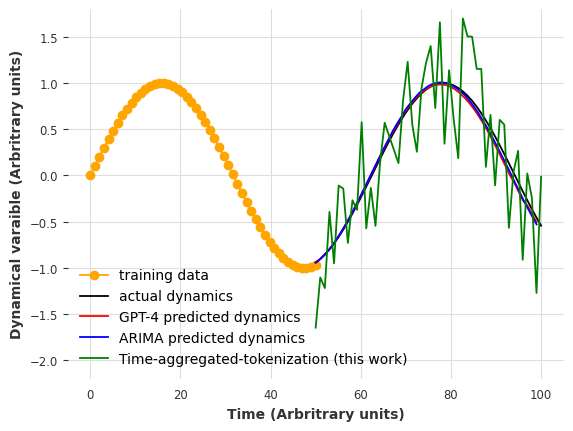

In [53]:

plt.plot(np.linspace(0,50,50),train,color = "orange",marker = 'o')
plt.plot(np.linspace(50,100,50),test,'k')
plt.plot(pred_dict_gpt_sine['median'],'r')
plt.plot(pred_dict_arima_sine['median'],'b')
plt.plot(np.linspace(50,100,50),df_sine['preds'],'g')
plt.xlabel('Time (Arbritrary units)')
plt.ylabel('Dynamical varaible (Arbritrary units)')
plt.ylim([-2.2 ,1.8])

plt.legend(["training data","actual dynamics", "GPT-4 predicted dynamics","ARIMA predicted dynamics","Time-aggregated-tokenization (this work)"], loc="lower left")
plt.savefig('oscillator_rebuttal.png')



In [8]:
import pandas as pd

df_sine = pd.read_csv('./fine_tuned_results/sinetest1_preds.csv')

In [15]:
df_forced_oscillators = pd.read_csv('./fine_tuned_results/')

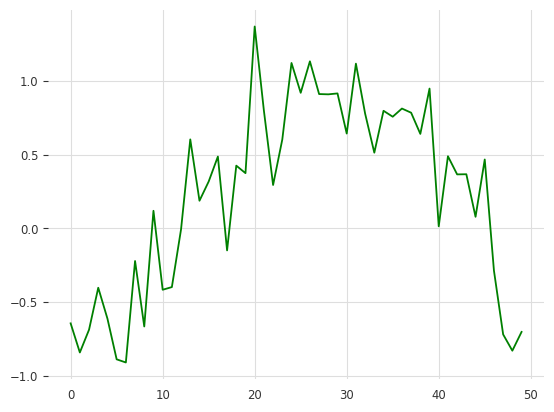

In [16]:
plt.plot(df_forced_oscillators['preds'],'g')


In [17]:
x2 = np.linspace(0,10,100)
train2 = np.sin(x2[0:50]) + 0.2*np.sin(x2[0:50]*10) + 0.03*np.sin(x2[0:50]*20)
test2 = np.sin(x2[50:100]) + 0.2*np.sin(x2[50:100]*10) + 0.03*np.sin(x2[50:100]*20)

In [26]:
pred_dict_gpt_sum = get_autotuned_predictions_data(train2, test2, hypers, 10, model_predict_fns['LLMTime GPT-4'], verbose=False, parallel=False)

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan')}) 
 with NLL inf


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.57s/it]

In [27]:
pred_dict_arima_sum = get_autotuned_predictions_data(train2, test2, hypers, 10, model_predict_fns['ARIMA'], verbose=False, parallel=False)


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan')}) 
 with NLL inf


/Users/rdey33/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/rdey33/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


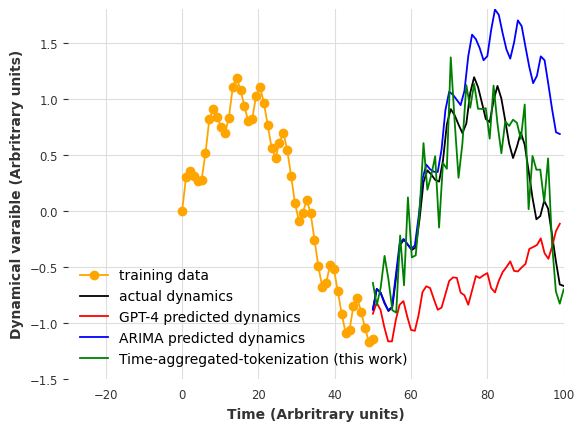

In [50]:

plt.plot(np.linspace(0,50,50),train2,color = "orange",marker = 'o')
plt.plot(np.linspace(50,100,50),test2,'k')
plt.plot(pred_dict_gpt_sum['median'],'r')
plt.plot(pred_dict_arima_sum['median'],'b')
plt.plot(np.linspace(50,100,50),df_forced_oscillators['preds'],'g')
plt.xlabel('Time (Arbritrary units)')
plt.ylabel('Dynamical varaible (Arbritrary units)')
plt.legend(["training data","actual dynamics", "GPT-4 predicted dynamics","ARIMA predicted dynamics","Time-aggregated-tokenization (this work)"], loc="lower left")
plt.xlim([-30 ,100])
plt.ylim([-1.5 ,1.8])

plt.savefig('oscillator_sum_rebuttal.png')

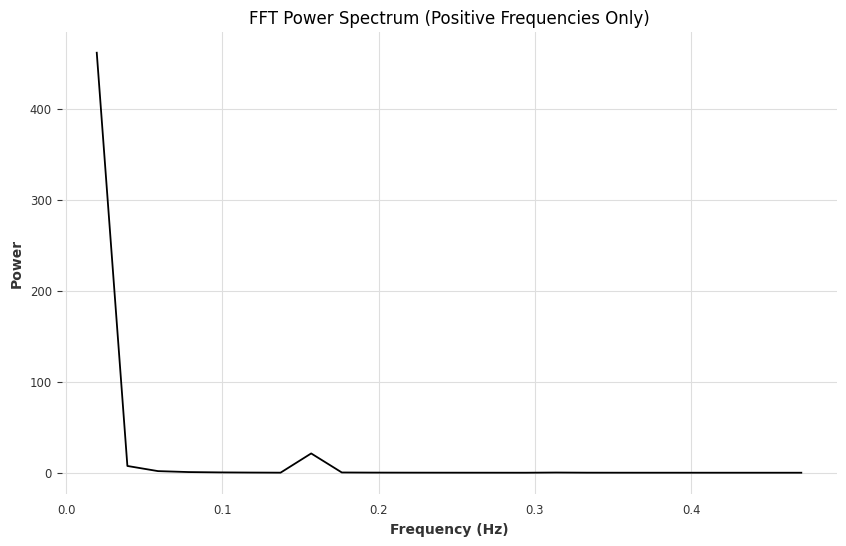

In [41]:
time = np.linspace(50,100,50)


fft_result = np.fft.fft(test2)
fft_freq = np.fft.fftfreq(len(test2), time[1] - time[0])  # Frequency axis

# Calculate the squared amplitude or power
fft_power = np.abs(fft_result) ** 2

# Plot the results for positive frequencies only
positive_freq_mask = fft_freq > 0
plt.figure(figsize=(10, 6))
plt.plot(fft_freq[positive_freq_mask], fft_power[positive_freq_mask])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('FFT Power Spectrum (Positive Frequencies Only)')
plt.grid(True)
plt.show()

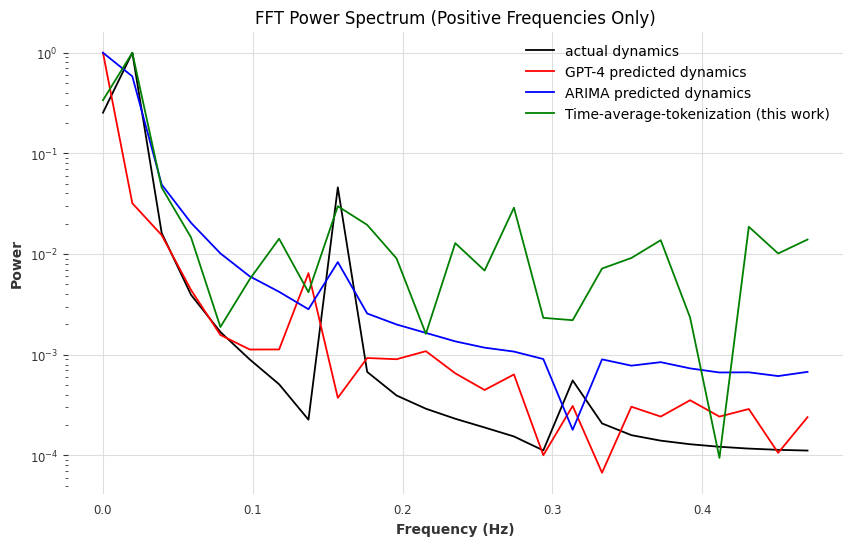

In [47]:
fft_result_gpt = np.fft.fft(pred_dict_gpt_sum['median'])
fft_freq_gpt = np.fft.fftfreq(len(pred_dict_gpt_sum['median']), time[1] - time[0])  # Frequency axis
# Calculate the squared amplitude or power
fft_power_gpt = np.abs(fft_result_gpt) ** 2


fft_result_arima = np.fft.fft(pred_dict_arima_sum['median'])
fft_freq_arima = np.fft.fftfreq(len(pred_dict_arima_sum['median']), time[1] - time[0])  # Frequency axis
# Calculate the squared amplitude or power
fft_power_arima = np.abs(fft_result_arima) ** 2


fft_results_finetuned = np.fft.fft(df_forced_oscillators['preds'])
fft_freq_finetuned = np.fft.fftfreq(len(df_forced_oscillators['preds']), time[1] - time[0])  # Frequency axis
fft_power_finetuned = np.abs(fft_results_finetuned) ** 2




# Normalize the power spectrum
fft_power = fft_power / np.max(fft_power)
fft_power_arima = fft_power_arima / np.max(fft_power_arima)
fft_power_gpt = fft_power_gpt / np.max(fft_power_gpt)
fft_power_finetuned = fft_power_finetuned / np.max(fft_power_finetuned)

## fft for the fine tuned


# Plot the results for positive frequencies only
positive_freq_mask = fft_freq >= 0
plt.figure(figsize=(10, 6))
plt.plot(fft_freq[positive_freq_mask], fft_power[positive_freq_mask],'k')
plt.plot(fft_freq_gpt[positive_freq_mask], fft_power_gpt[positive_freq_mask],'r')
plt.plot(fft_freq_arima[positive_freq_mask], fft_power_arima[positive_freq_mask],'b')
plt.plot(fft_freq_finetuned[positive_freq_mask], fft_power_finetuned[positive_freq_mask],'g')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('FFT Power Spectrum (Positive Frequencies Only)')
plt.yscale("log")
plt.grid(True)
plt.legend(["actual dynamics", "GPT-4 predicted dynamics","ARIMA predicted dynamics","Time-average-tokenization (this work)"], loc="upper right")
plt.savefig('PSD-oscillator_rebuttal.png')
plt.show()


In [55]:

df_ar = pd.read_csv('./fine_tuned_results/artest3_preds.csv')

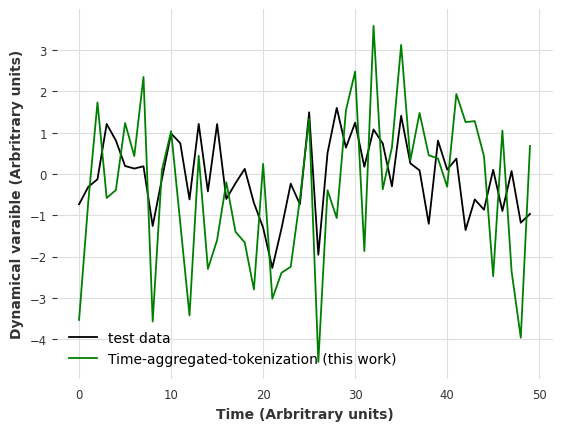

In [59]:
plt.plot(df_ar['true'],'k')
plt.plot(df_ar['preds'],'g')
plt.xlabel('Time (Arbritrary units)')
plt.ylabel('Dynamical varaible (Arbritrary units)')
plt.legend(["test data", "Time-aggregated-tokenization (this work)"], loc="lower left")

plt.savefig('finetuned_ar_rebuttal.png')

In [61]:
import numpy as np
from scipy.linalg import toeplitz
from scipy.linalg import solve_toeplitz

def estimate_AR_coefficients(signal, order):
    # Construct the Yule-Walker equations
    autocorr = np.correlate(signal, signal, mode='full') / len(signal)
    R = toeplitz(autocorr[:order])
    r = autocorr[1:order+1]
    
    # Solve the Yule-Walker equations to find AR coefficients
    ar_coefficients = solve_toeplitz(R, r)
    return ar_coefficients

# Example usage:
# Generate a synthetic time series
np.random.seed(0)
time_series = np.random.randn(1000)

# Estimate AR coefficients of order 3
order = 3
ar_coefficients = estimate_AR_coefficients(time_series, order)
print("Estimated AR coefficients:", ar_coefficients)


ValueError: Incompatible dimensions.

In [77]:
import numpy as np
import statsmodels as sm

# Example usage:
# Generate a synthetic time series
np.random.seed(0)
time_series = df_ar['preds']


# Fit AR model
order = 3  # Change the order as needed
res = sm.tsa.ar_model.AutoRegResults(time_series, lags=4).fit()
out = 'AIC: {0:0.3f}, HQIC: {1:0.3f}, BIC: {2:0.3f}'
print(out.format(res.aic, res.hqic, res.bic))

time_series_original = df_ar['true']
res_original = sm.tsa.ar_model.AutoReg(time_series_original, lags=4).fit()
print(out.format(res_original.aic, res_original.hqic, res_original.bic))

AIC: 193.880, HQIC: 197.990, BIC: 204.851
AIC: 131.989, HQIC: 136.099, BIC: 142.961


In [73]:
res.

[1, 2, 3, 4]

In [79]:
res = sm.tsa.ar_model.AutoRegResults(time_series)

TypeError: __init__() missing 2 required positional arguments: 'params' and 'cov_params'

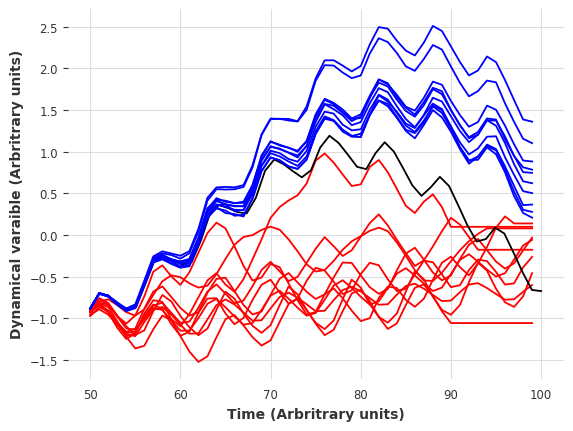

In [90]:
plt.plot(pred_dict_gpt_sum['samples'].T,'r')
plt.plot(np.linspace(50,100,50),test2,'k')
plt.plot(pred_dict_arima_sum['samples'].T,'b')
plt.xlabel('Time (Arbritrary units)')
plt.ylabel('Dynamical varaible (Arbritrary units)')
plt.savefig('prob_oscillator_sum.png')

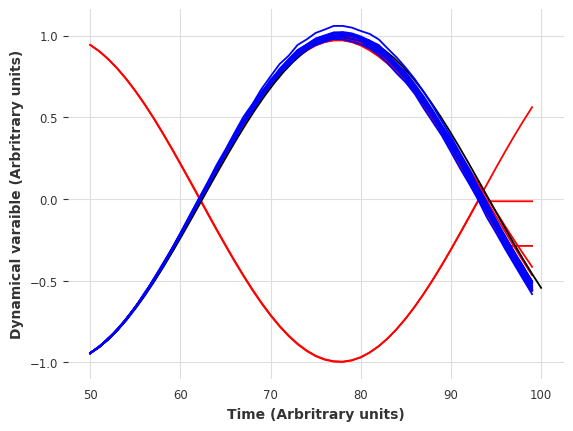

In [91]:
plt.plot(pred_dict_gpt_sine['samples'].T,'r')
plt.plot(np.linspace(50,100,50),test,'k')
plt.plot(pred_dict_arima_sine['samples'].T,'b')
plt.xlabel('Time (Arbritrary units)')
plt.ylabel('Dynamical varaible (Arbritrary units)')
plt.savefig('prob_oscillator.png')

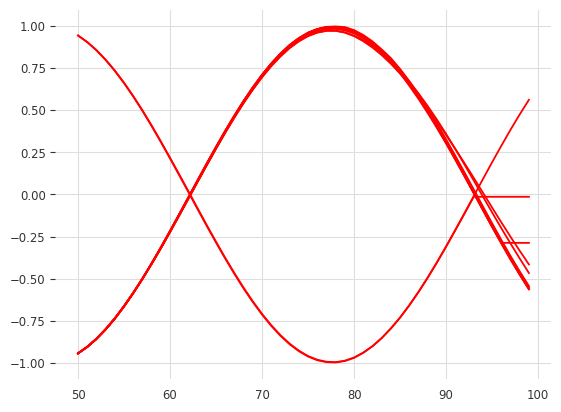

In [94]:
plt.plot(pred_dict_gpt_sine['samples'].T,'r')

In [106]:
ar_train = pd.read_csv('./synthetic_data/artrain3.csv')
ar_test = pd.read_csv('./synthetic_data/artest3.csv')


In [109]:
ar_test

,Unnamed: 0,0
0,0,-0.732764
1,1,-0.311993
2,2,-0.128021
3,3,1.210526
4,4,0.810410
5,5,0.193516
6,6,0.131824
7,7,0.186425
8,8,-1.258437
9,9,-0.123339


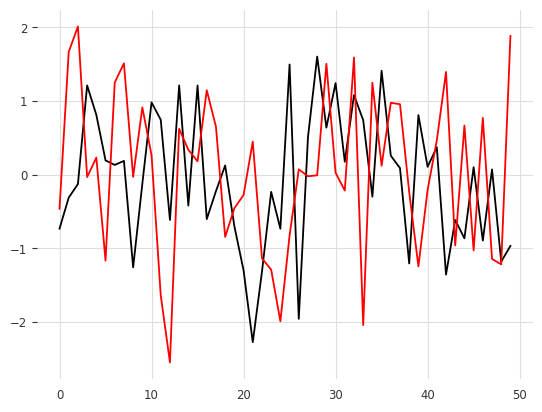

In [107]:
plt.plot(ar_test['0'])
plt.plot(ar_train['0'],'r')

In [110]:
pred_dict_gpt_ar2 = get_autotuned_predictions_data(ar_train['0'], ar_test['0'], hypers, 10, model_predict_fns['LLMTime GPT-4'], verbose=False, parallel=False)

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan')}) 
 with NLL inf


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.24s/it]

In [111]:
pred_dict_arima_ar2 = get_autotuned_predictions_data(ar_train['0'], ar_test['0'], hypers, 10, model_predict_fns['ARIMA'], verbose=False, parallel=False)

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan')}) 
 with NLL inf


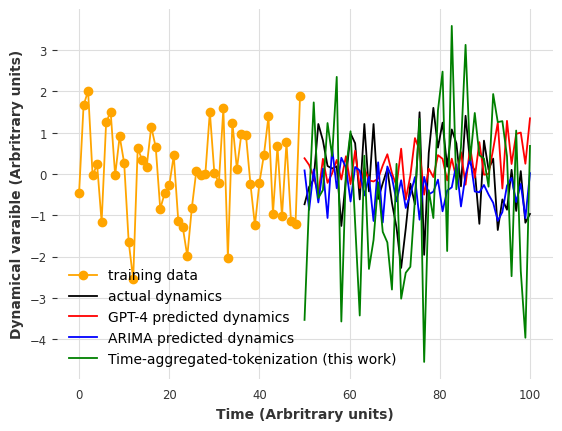

In [128]:
plt.plot(ar_train['0'],color = "orange",marker = 'o')
plt.plot(np.linspace(50,100,50),ar_test['0'],'k')
plt.plot(np.linspace(50,100,50),pred_dict_gpt_ar2['median'],'r')
plt.plot(np.linspace(50,100,50),pred_dict_arima_ar2['median'],'b')
plt.plot(np.linspace(50,100,50),df_ar['preds'],'g')
plt.xlabel('Time (Arbritrary units)')
plt.ylabel('Dynamical varaible (Arbritrary units)')
plt.legend(["training data","actual dynamics", "GPT-4 predicted dynamics","ARIMA predicted dynamics","Time-aggregated-tokenization (this work)"], loc="lower left")
plt.savefig('ar_combined.png')


In [114]:
import numpy as np
def calculate_mse(array1, array2):
    mse = np.mean((array1 - array2) ** 2)
    return mse
    

In [118]:
mse_gpt = calculate_mse(ar_test['0'],pred_dict_gpt_ar2['median'])

In [117]:
mse_arima = calculate_mse(ar_test['0'],pred_dict_arima_ar2['median'])

In [115]:
mse_token = calculate_mse(ar_test['0'],df_ar['preds'])

In [116]:
mse_token

2.942647099144011

In [119]:
mse_gpt

1.2852224991592183

In [120]:
mse_arima

1.211678227932554

In [121]:
import numpy as np

def cosine_similarity(series1, series2):
    """
    Compute cosine similarity between two equal-length time series.
    
    Parameters:
    series1 (array-like): First time series.
    series2 (array-like): Second time series.
    
    Returns:
    float: Cosine similarity between the two time series.
    """
    # Convert series to numpy arrays
    series1 = np.array(series1)
    series2 = np.array(series2)
    
    # Compute dot product
    dot_product = np.dot(series1, series2)
    
    # Compute magnitudes
    magnitude1 = np.linalg.norm(series1)
    magnitude2 = np.linalg.norm(series2)
    
    # Compute cosine similarity
    cosine_sim = dot_product / (magnitude1 * magnitude2)
    
    return cosine_sim


In [122]:
cosine_similarity(ar_test['0'],pred_dict_gpt_ar2['median'])

-0.16958311408098217

In [123]:
cosine_similarity(ar_test['0'],pred_dict_arima_ar2['median'])

-0.02351871609140003

In [124]:
cosine_similarity(ar_test['0'],df_ar['preds'])

0.47197640283115444

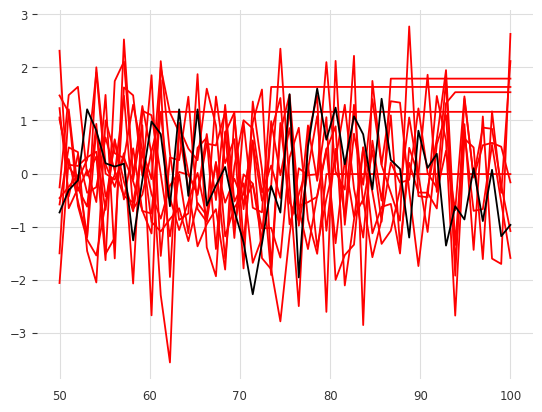

In [133]:
plt.plot(np.linspace(50,100,50),pred_dict_gpt_ar2['samples'].T,'r')
plt.plot(np.linspace(50,100,50),ar_test['0'],'k')

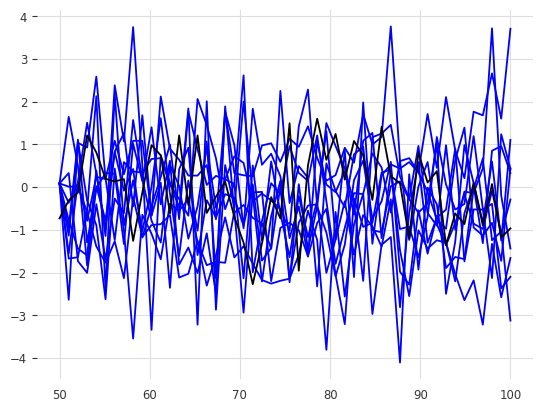

In [134]:
plt.plot(np.linspace(50,100,50),pred_dict_arima_ar2['samples'].T,'b')
plt.plot(np.linspace(50,100,50),ar_test['0'],'k')